In [1]:
import pandas as pd
df = pd.read_csv("customer_shopping_data.csv")
print(df.head())

  invoice_no customer_id  gender  age  category  quantity    price  \
0    I138884     C241288  Female   28  Clothing         5  1500.40   
1    I317333     C111565    Male   21     Shoes         3  1800.51   
2    I127801     C266599    Male   20  Clothing         1   300.08   
3    I173702     C988172  Female   66     Shoes         5  3000.85   
4    I337046     C189076  Female   53     Books         4    60.60   

  payment_method invoice_date   shopping_mall  
0    Credit Card     5/8/2022          Kanyon  
1     Debit Card   12/12/2021  Forum Istanbul  
2           Cash    9/11/2021       Metrocity  
3    Credit Card   16/05/2021    Metropol AVM  
4           Cash   24/10/2021          Kanyon  


In [2]:
print(df.describe())

                age      quantity         price
count  99457.000000  99457.000000  99457.000000
mean      43.427089      3.003429    689.256321
std       14.990054      1.413025    941.184567
min       18.000000      1.000000      5.230000
25%       30.000000      2.000000     45.450000
50%       43.000000      3.000000    203.300000
75%       56.000000      4.000000   1200.320000
max       69.000000      5.000000   5250.000000


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB
None


In [4]:
print(df.isnull().sum()) #missing values

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64


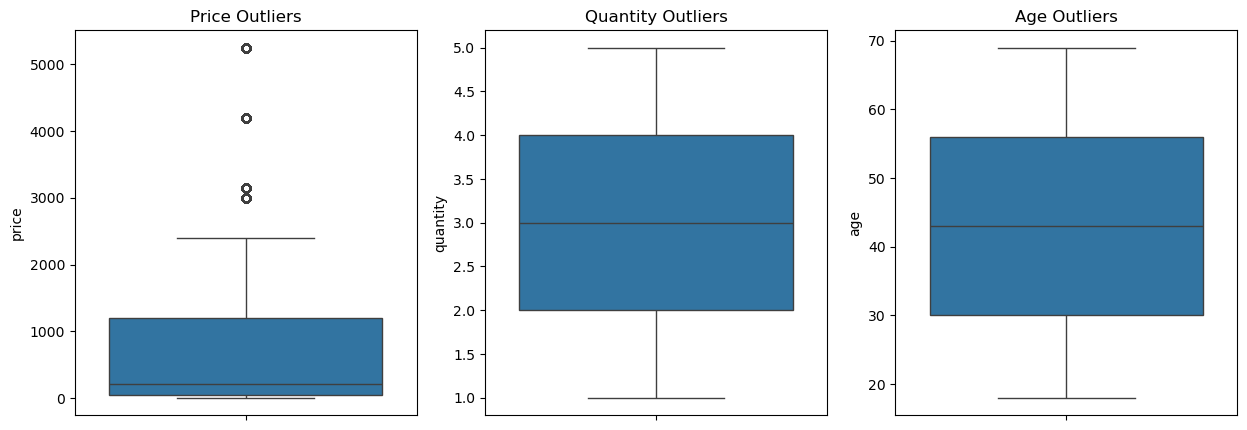

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)  # Boxplot for price
sns.boxplot(y=df["price"])
plt.title("Price Outliers")

plt.subplot(1, 3, 2)  # Boxplot for quantity
sns.boxplot(y=df["quantity"])
plt.title("Quantity Outliers")

plt.subplot(1, 3, 3)  # Boxplot for age
sns.boxplot(y=df["age"])
plt.title("Age Outliers")

plt.show()

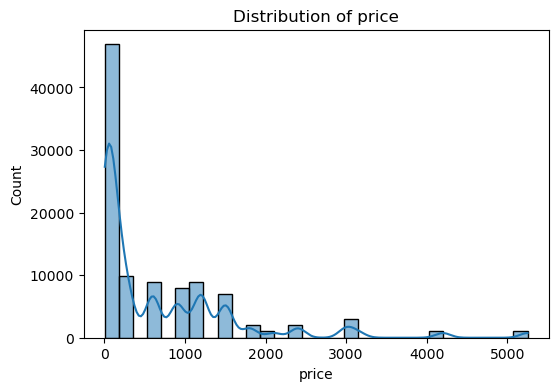

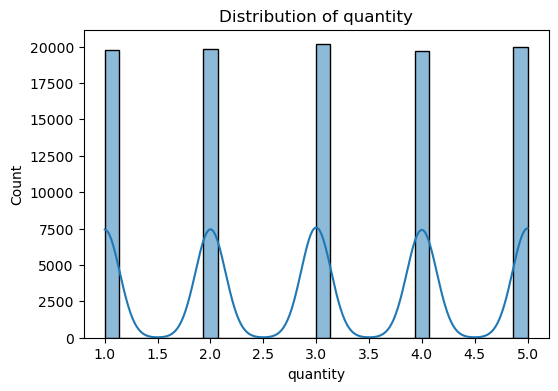

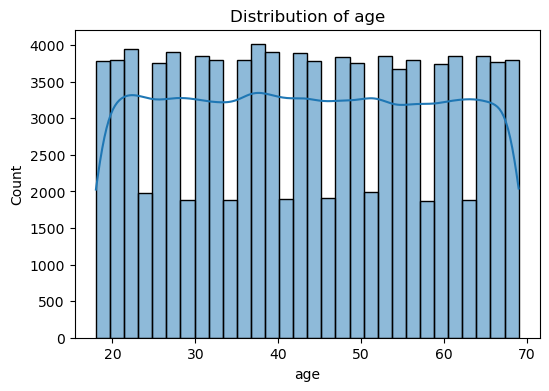

In [6]:
features = ["price", "quantity", "age"]
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

In [9]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df = remove_outliers_iqr(df, 'price')
df = remove_outliers_iqr(df, 'quantity')

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Convert date
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True)

# Total amount per transaction
df['total_amount'] = df['quantity'] * df['price']

# Aggregate at customer level
agg_df = df.groupby("customer_id").agg({
    "gender": "first",
    "age": "first",
    "total_amount": "sum",
    "invoice_no": "nunique",
    "quantity": "sum",
    "category": pd.Series.nunique,
    "shopping_mall": pd.Series.nunique,
    "payment_method": pd.Series.nunique,
    "invoice_date": ["max", "min"]
}).reset_index()

# Flatten multi-index column names
agg_df.columns = [
    "customer_id", "gender", "age", "total_spent", "num_transactions",
    "total_quantity", "unique_categories", "unique_malls", "unique_payment_methods",
    "last_purchase", "first_purchase"
]

# Recency & customer lifetime
latest_date = df["invoice_date"].max()
agg_df["recency_days"] = (latest_date - agg_df["last_purchase"]).dt.days
agg_df["customer_lifetime_days"] = (agg_df["last_purchase"] - agg_df["first_purchase"]).dt.days

# Average order value & average items per order
agg_df["avg_order_value"] = agg_df["total_spent"] / agg_df["num_transactions"]
agg_df["avg_items_per_order"] = agg_df["total_quantity"] / agg_df["num_transactions"]

# Diversity spending metrics
agg_df["avg_spent_per_category"] = agg_df["total_spent"] / agg_df["unique_categories"]
agg_df["avg_spent_per_mall"] = agg_df["total_spent"] / agg_df["unique_malls"]

# Encode gender
le = LabelEncoder()
agg_df["gender"] = le.fit_transform(agg_df["gender"])

# Features for clustering
features = [
    "gender", "age", "total_spent", "num_transactions",
    "total_quantity", "unique_categories", "unique_malls",
    "unique_payment_methods", "recency_days", "customer_lifetime_days",
    "avg_order_value", "avg_items_per_order",
    "avg_spent_per_category", "avg_spent_per_mall"
]

X = agg_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
print("Aggregated Customer Features:")
print(agg_df.head())

print("\nShape of X_scaled:", X_scaled.shape)

print("\nFirst 5 scaled feature rows:")
print(X_scaled[:5])

Aggregated Customer Features:
  customer_id  gender  age  total_spent  num_transactions  total_quantity  \
0     C100004       1   61      7502.00                 1               5   
1     C100005       1   34      2400.68                 1               2   
2     C100006       1   44       322.56                 1               3   
3     C100012       1   25       130.75                 1               5   
4     C100019       0   21        35.84                 1               1   

   unique_categories  unique_malls  unique_payment_methods last_purchase  \
0                  1             1                       1    2021-11-26   
1                  1             1                       1    2023-03-03   
2                  1             1                       1    2022-12-01   
3                  1             1                       1    2021-08-15   
4                  1             1                       1    2021-07-25   

  first_purchase  recency_days  customer_lifetime_

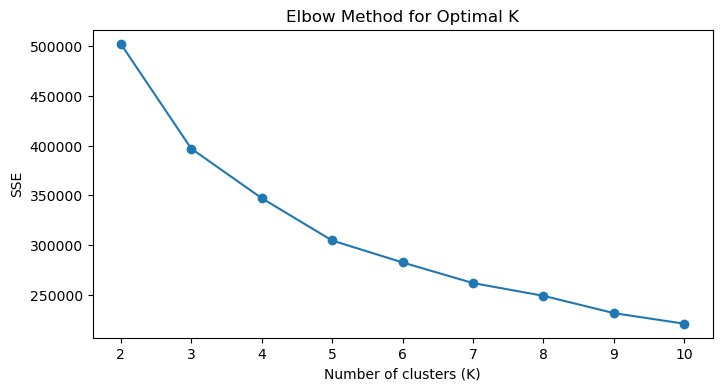

K=2 → Silhouette Score: 0.4346
K=3 → Silhouette Score: 0.2669
K=4 → Silhouette Score: 0.2707
K=5 → Silhouette Score: 0.2635
K=6 → Silhouette Score: 0.2596
K=7 → Silhouette Score: 0.2487
K=8 → Silhouette Score: 0.2454
K=9 → Silhouette Score: 0.2465
K=10 → Silhouette Score: 0.2551

Cluster Summary:
            gender        age  total_spent  num_transactions  total_quantity  \
cluster                                                                       
0        0.402952  43.490994  6465.496990               1.0        4.276640   
1        1.000000  43.314810   766.542243               1.0        1.950838   
2        0.400312  43.380902   489.684503               1.0        4.504651   
3        0.000000  43.506319   773.378783               1.0        1.955307   

         unique_categories  unique_malls  unique_payment_methods  \
cluster                                                            
0                      1.0           1.0                     1.0   
1                     

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# using Elbow menthod
sse = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")
plt.show()

# Silhouette score
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    print(f"K={k} → Silhouette Score: {sil_score:.4f}")

# K means Clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
agg_df["cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = agg_df.groupby("cluster").mean(numeric_only=True)
print("\nCluster Summary:\n", cluster_summary)

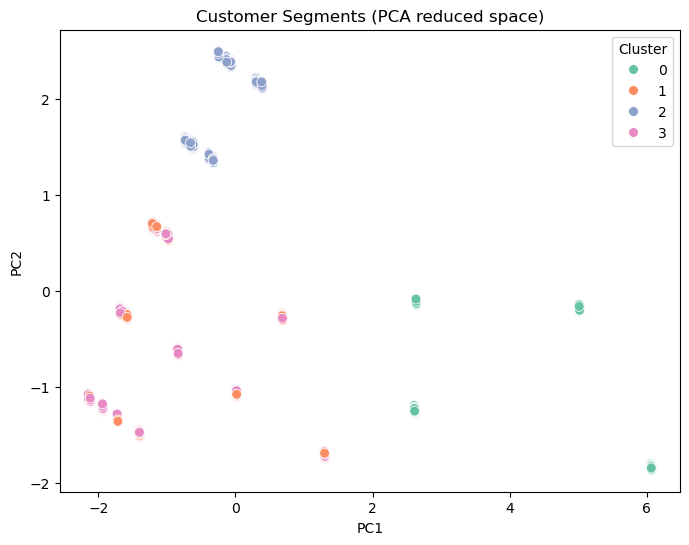

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

df_clusters = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
df_clusters["Cluster"] = kmeans.labels_

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clusters, x="PC1", y="PC2", hue="Cluster", palette="Set2", s=50)
plt.title("Customer Segments (PCA reduced space)")
plt.show()

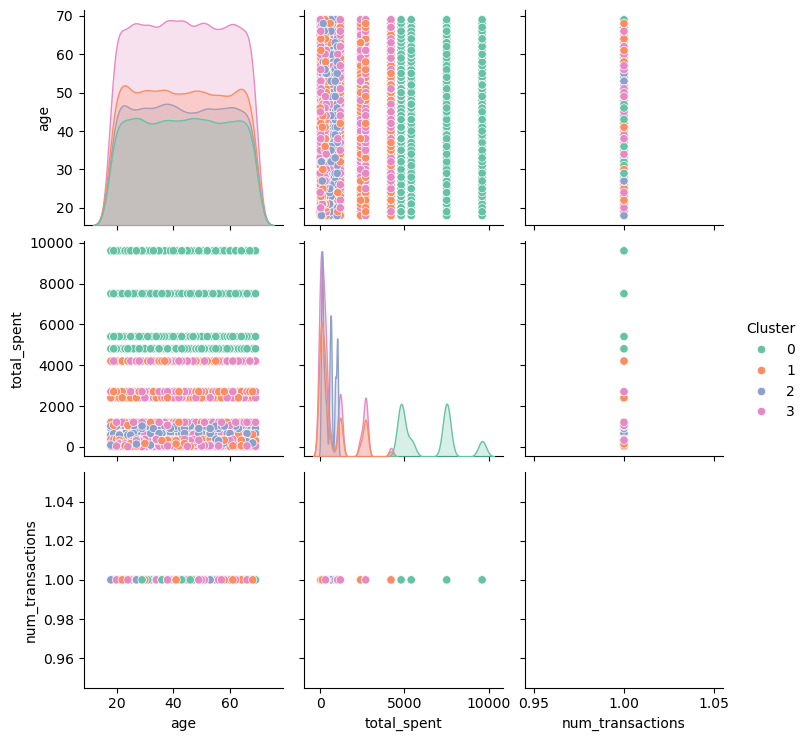

In [20]:
agg_df["Cluster"] = kmeans.labels_
sns.pairplot(agg_df, vars=["age", "total_spent", "num_transactions"], hue="Cluster", palette="Set2")
plt.show()

In [21]:
cluster_summary = agg_df.groupby("Cluster").agg({
    "age": "mean",
    "total_spent": ["mean", "sum"],
    "num_transactions": "mean",
    "total_quantity": "mean",
    "unique_categories": "mean",
    "recency_days": "mean"
}).round(2)

print(cluster_summary)

           age total_spent               num_transactions total_quantity  \
          mean        mean           sum             mean           mean   
Cluster                                                                    
0        43.49     6465.50  1.152216e+08              1.0           4.28   
1        43.31      766.54  1.746337e+07              1.0           1.95   
2        43.38      489.68  9.738356e+06              1.0           4.50   
3        43.51      773.38  2.625080e+07              1.0           1.96   

        unique_categories recency_days  
                     mean         mean  
Cluster                                 
0                     1.0       399.31  
1                     1.0       395.78  
2                     1.0       395.67  
3                     1.0       397.67  


In [22]:
cluster_labels = {
    0: "High-Value Loyalists",
    1: "Bargain Shoppers",
    2: "Occasional Buyers",
    3: "At-Risk Customers"
}

agg_df["Segment"] = agg_df["Cluster"].map(cluster_labels)

C:\Users\Evangeline T\AppData\Local\Temp\ipykernel_15892\2554588239.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=agg_df, x="Segment", order=agg_df["Segment"].value_counts().index, palette="Set2")


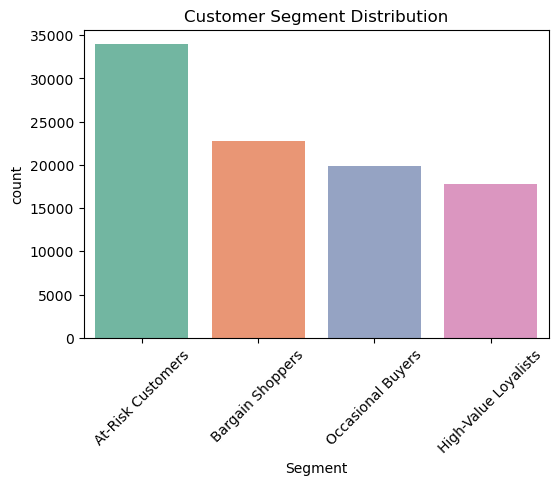

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(data=agg_df, x="Segment", order=agg_df["Segment"].value_counts().index, palette="Set2")
plt.title("Customer Segment Distribution")
plt.xticks(rotation=45)
plt.show()